In [1]:
import warnings
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.tools.plotting import autocorrelation_plot
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
import operator

In [2]:
%matplotlib inline

In [3]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

In [4]:
def readFile(filename):
    
    print("=====WV: House Price Index File=====")
    dateparse = lambda dates: pd.datetime.strptime(dates, '%Y')
    df_1 = pd.read_csv(filename, header=0,parse_dates=[0],index_col=0,date_parser=dateparse)
    print("File read into dataframe.")
    print(df_1.shape)
    df_1 = df_1.sort()
    return df_1

In [5]:
WV_HPI = readFile("WV_HousePriceIndex.csv")

=====WV: House Price Index File=====
File read into dataframe.
(39, 1)


In [6]:
WV_HPI.index

DatetimeIndex(['1977-01-01', '1978-01-01', '1979-01-01', '1980-01-01',
               '1981-01-01', '1982-01-01', '1983-01-01', '1984-01-01',
               '1985-01-01', '1986-01-01', '1987-01-01', '1988-01-01',
               '1989-01-01', '1990-01-01', '1991-01-01', '1992-01-01',
               '1993-01-01', '1994-01-01', '1995-01-01', '1996-01-01',
               '1997-01-01', '1998-01-01', '1999-01-01', '2000-01-01',
               '2001-01-01', '2002-01-01', '2003-01-01', '2004-01-01',
               '2005-01-01', '2006-01-01', '2007-01-01', '2008-01-01',
               '2009-01-01', '2010-01-01', '2011-01-01', '2012-01-01',
               '2013-01-01', '2014-01-01', '2015-01-01'],
              dtype='datetime64[ns]', freq=None)

In [7]:
WV_HPI.rename(columns={'WV_House Price Index': 'WV_HousePriceIndex'}, inplace=True)

In [8]:
WV_HPI.head()

,WV_HousePriceIndex
1977-01-01,79.0025
1978-01-01,86.6725
1979-01-01,92.5150
1980-01-01,107.2850
1981-01-01,104.2350


In [9]:
WV_HPI.dtypes

WV_HousePriceIndex    float64
dtype: object

In [9]:
WV_HPI.WV_HousePriceIndex.describe()

count          39
unique         39
top       86.6725
freq            1
Name: WV_HousePriceIndex, dtype: object

In [10]:
WV_HPI.WV_HousePriceIndex = pd.to_numeric(WV_HPI.WV_HousePriceIndex,errors = 'coerce')
WV_HPI.dtypes


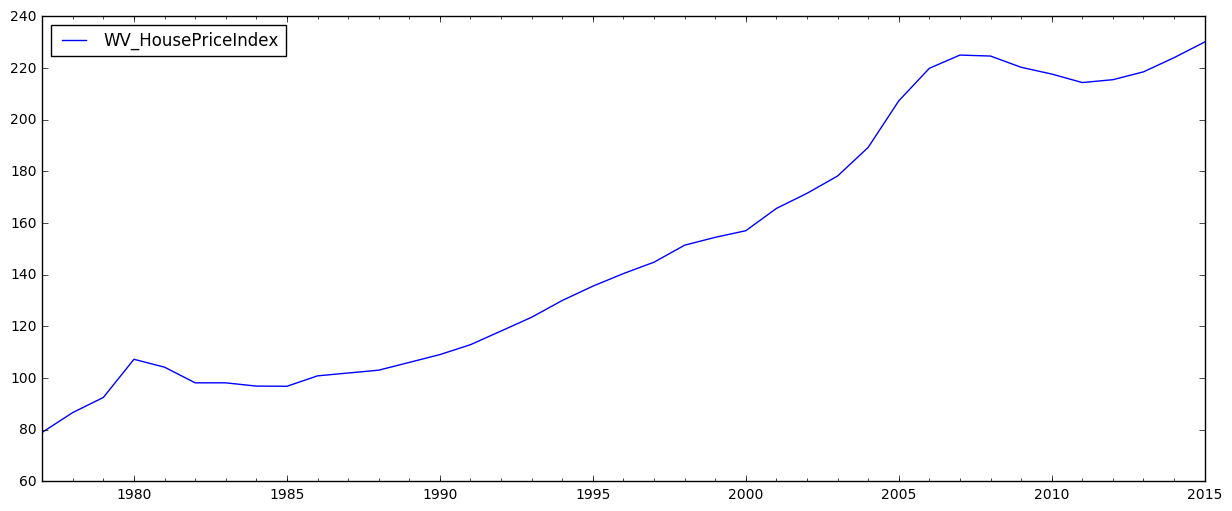

In [10]:
WV_HPI.plot(figsize=(15,6))
plt.show()

    There is an overall increasing trend in the data. WE have some missing data for year 1982. We can see some dip also in year 2007 till 2011.

In [12]:
WV_HPI = WV_HPI.fillna(WV_HPI.bfill())


In [45]:
WV_HPI

,WV_HousePriceIndex
1977-01-01,79.0025
1978-01-01,86.6725
1979-01-01,92.5150
1980-01-01,107.2850
1981-01-01,104.2350
1982-01-01,98.1725
1983-01-01,98.1725
1984-01-01,96.9125
1985-01-01,96.8375
1986-01-01,100.8650


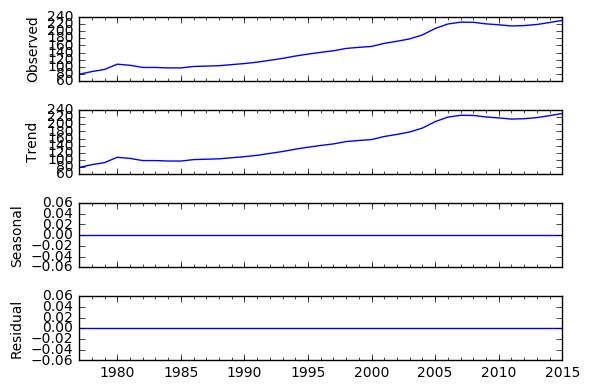

In [13]:
#Decomposing into  trend, seasonal and residual using additive model.
decomposition = sm.tsa.seasonal_decompose(WV_HPI, model='additive')
fig = decomposition.plot()
plt.show()
#fig.savefig('Seasonal_Decompose.png', dpi=150)

# Stationarity

We are taking two techniques to check if the dataset is stationary or not. First, check the mean and variance. Second, Dickey-Fuller test.

Plotting Rolling Statistics: We can plot the moving average or moving variance and see if it varies with time. By moving average/variance I mean that at any instant ‘t’, we’ll take the average/variance of the last year, i.e. last 12 months. But again this is more of a visual technique.

Dickey-Fuller Test: This is one of the statistical tests for checking stationarity. Here the null hypothesis is that the TS is non-stationary. The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary. Refer this article for details.

In [14]:
#we can split our dataset and calculate the mean and variance for each group.
def meanVarianceCheck(df):
    X = df.values
    split = len(X) / 2
    X1, X2 = X[0:split], X[split:]
    mean1, mean2 = X1.mean(), X2.mean()
    var1, var2 = X1.var(), X2.var()
    return ('mean1=%f, mean2=%f' % (mean1, mean2), 'variance1=%f, variance2=%f' % (var1, var2))

In [15]:
meanVarianceCheck(WV_HPI)

('mean1=105.329605, mean2=193.534875',
 'variance1=188.955211, variance2=964.272331')

In [16]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=5)
    rolstd = pd.rolling_std(timeseries, window=5)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

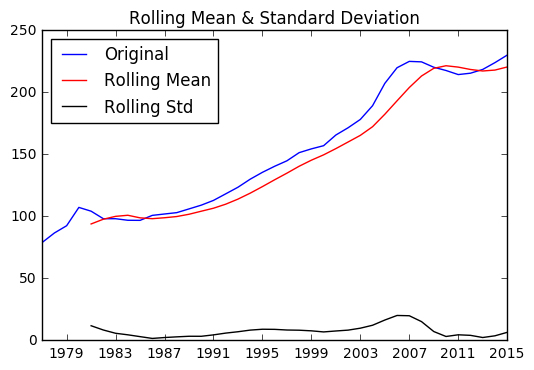

Results of Dickey-Fuller Test:
Test Statistic                 -0.041681
p-value                         0.954946
#Lags Used                      2.000000
Number of Observations Used    36.000000
Critical Value (5%)            -2.945951
Critical Value (1%)            -3.626652
Critical Value (10%)           -2.611671
dtype: float64


In [17]:
test_stationarity(WV_HPI.WV_HousePriceIndex)

# Estimating & Eliminating Trend

In [11]:
#log transform
def logTransform(df):
    ts_log = np.log(df)
    plt.plot(ts_log)
    return ts_log

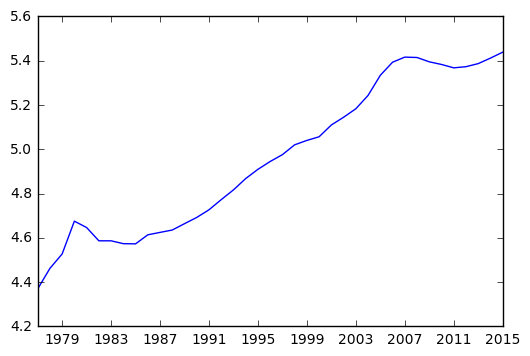

In [12]:
ts_log = logTransform(WV_HPI)

In [13]:
test_stationarity(ts_log.WV_HousePriceIndex)

NameError: name 'test_stationarity' is not defined

In [21]:
#Differencing - taking the differece with a particular time lag
def logFirstDifference(ts_log):
    ts_log_diff = ts_log - ts_log.shift()
    ts_log_diff.dropna(inplace=True)
    return ts_log_diff

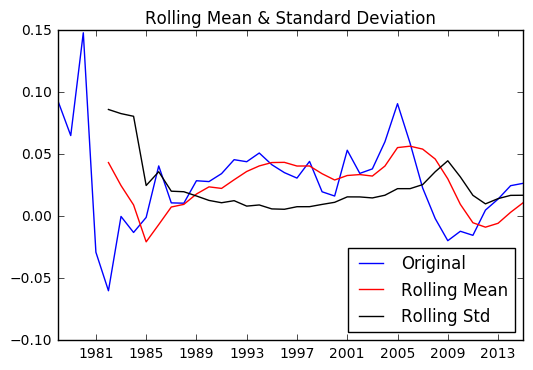

Results of Dickey-Fuller Test:
Test Statistic                 -3.402491
p-value                         0.010874
#Lags Used                      1.000000
Number of Observations Used    36.000000
Critical Value (5%)            -2.945951
Critical Value (1%)            -3.626652
Critical Value (10%)           -2.611671
dtype: float64


In [22]:
ts_log_diff = logFirstDifference(ts_log)
test_stationarity(ts_log_diff.WV_HousePriceIndex)

In [23]:
def firstDifference(df):
    ts_first_diff = df - df.shift()
    ts_first_diff.dropna(inplace=True)
    return ts_first_diff

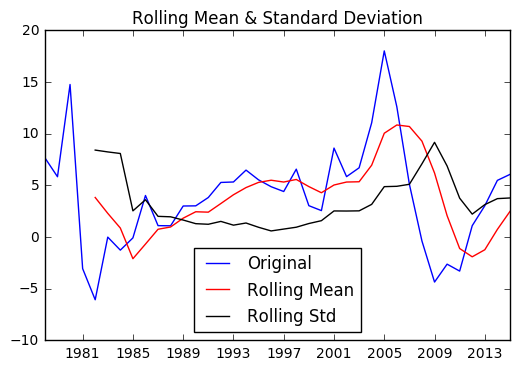

Results of Dickey-Fuller Test:
Test Statistic                 -3.002709
p-value                         0.034642
#Lags Used                      1.000000
Number of Observations Used    36.000000
Critical Value (5%)            -2.945951
Critical Value (1%)            -3.626652
Critical Value (10%)           -2.611671
dtype: float64


In [24]:
ts_first_diff = firstDifference(WV_HPI)
test_stationarity(ts_first_diff.WV_HousePriceIndex)

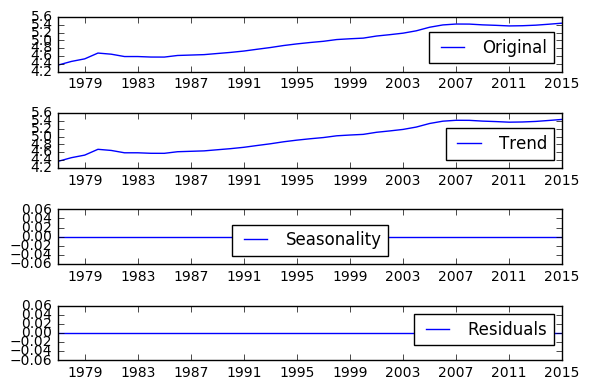

In [25]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

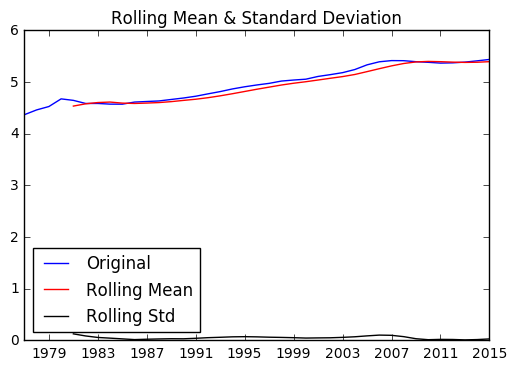

Results of Dickey-Fuller Test:
Test Statistic                 -0.415818
p-value                         0.907424
#Lags Used                      2.000000
Number of Observations Used    36.000000
Critical Value (5%)            -2.945951
Critical Value (1%)            -3.626652
Critical Value (10%)           -2.611671
dtype: float64


In [26]:
ts_log_decompose = trend
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose.WV_HousePriceIndex)

In [70]:
lag_acf = acf(ts_log, nlags=10)
lag_pacf = pacf(ts_log, nlags=10, method='ols')

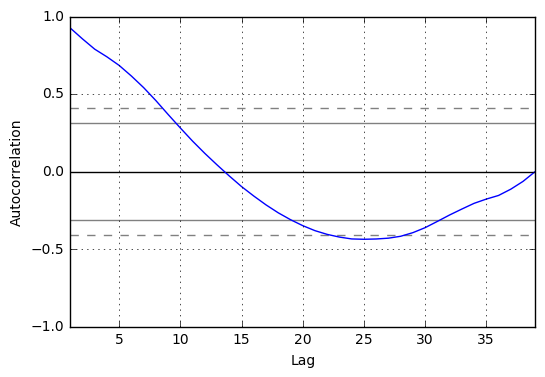

In [71]:
autocorrelation_plot(ts_log)
plt.show()

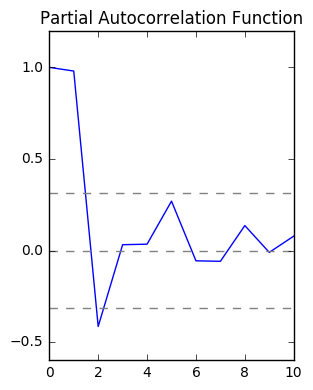

In [72]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [73]:
aic_metric = pd.DataFrame({'Modelname':[],'AIC':[]})
aic_dict = {} 

In [74]:
def cal_aic_metric(modelname,model):
    global aic_metric
    AIC = model.aic
    aic_dict[modelname] = AIC
    df_error = pd.DataFrame({'Modelname':[modelname],'AIC':[AIC]})
    aic_metric = pd.concat([aic_metric,df_error])
    return aic_metric

In [75]:
def AR_Model(ts):
    model = ARIMA(ts, order=(2, 0, 0))
    results_AR = model.fit(disp=0)
    cal_aic_metric('ARIMA(ts, order=(2, 0, 0))',results_AR)
    print('Lag: %s' % results_AR.k_ar)
    print('Coefficients: %s' % results_AR.params)
    print(results_AR.summary())
    plt.plot(ts_log)
    plt.plot(results_AR.fittedvalues, color='red')
    return results_AR

Lag: 2
Coefficients: const                       4.871314
ar.L1.WV_HousePriceIndex    1.653059
ar.L2.WV_HousePriceIndex   -0.659460
dtype: float64
                              ARMA Model Results                              
Dep. Variable:     WV_HousePriceIndex   No. Observations:                   39
Model:                     ARMA(2, 0)   Log Likelihood                  71.976
Method:                       css-mle   S.D. of innovations              0.035
Date:                Wed, 26 Apr 2017   AIC                           -135.952
Time:                        22:52:33   BIC                           -129.297
Sample:                    01-01-1977   HQIC                          -133.564
                         - 01-01-2015                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        4.8713

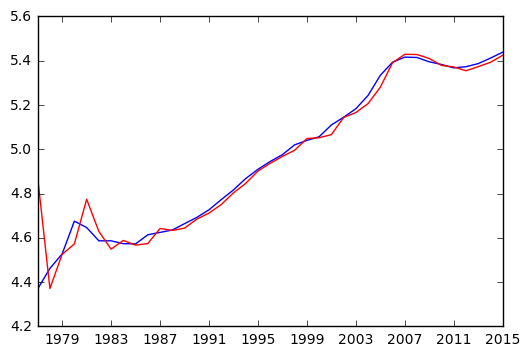

In [76]:
model_AR = AR_Model(ts_log)

In [77]:
def MA_Model(ts):
    model = ARIMA(ts_log, order=(0, 0, 2))  
    results_MA = model.fit(disp=0)
    cal_aic_metric('ARIMA(ts, order=(0, 0, 2))',results_MA)
    print('Lag: %s' % results_MA.k_ar)
    print('Coefficients: %s' % results_MA.params)
    print(results_MA.summary())
    plt.plot(ts_log)
    plt.plot(results_MA.fittedvalues, color='red')
    return results_MA

Lag: 0
Coefficients: const                       4.946464
ma.L1.WV_HousePriceIndex    1.907632
ma.L2.WV_HousePriceIndex    0.999939
dtype: float64
                              ARMA Model Results                              
Dep. Variable:     WV_HousePriceIndex   No. Observations:                   39
Model:                     ARMA(0, 2)   Log Likelihood                  30.208
Method:                       css-mle   S.D. of innovations              0.100
Date:                Wed, 26 Apr 2017   AIC                            -52.416
Time:                        22:52:53   BIC                            -45.761
Sample:                    01-01-1977   HQIC                           -50.028
                         - 01-01-2015                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        4.9465

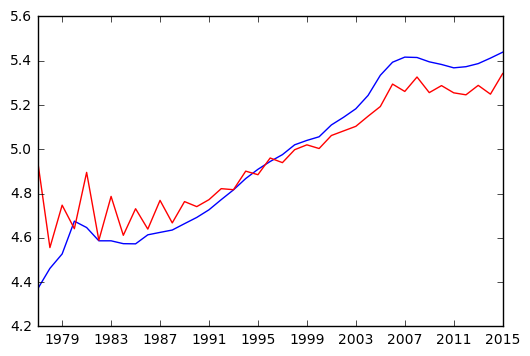

In [78]:
model_MA = MA_Model(ts_log)

In [79]:
def Combined_Model(ts):
    model = ARIMA(ts_log, order=(2, 0, 1))  
    results_ARIMA = model.fit(disp=0)
    cal_aic_metric('ARIMA(ts, order=(2, 0, 1))',results_ARIMA)
    print('Lag: %s' % results_ARIMA.k_ar)
    print('Coefficients: %s' % results_ARIMA.params)
    print(results_ARIMA.summary())
    plt.plot(ts_log)
    plt.plot(results_ARIMA.fittedvalues, color='red')
    return results_ARIMA

Lag: 2
Coefficients: const                      -89.597192
ar.L1.WV_HousePriceIndex     2.000000
ar.L2.WV_HousePriceIndex    -1.000000
ma.L1.WV_HousePriceIndex     0.997487
dtype: float64
                              ARMA Model Results                              
Dep. Variable:     WV_HousePriceIndex   No. Observations:                   39
Model:                     ARMA(2, 1)   Log Likelihood                -301.154
Method:                       css-mle   S.D. of innovations            601.048
Date:                Wed, 26 Apr 2017   AIC                            612.308
Time:                        22:53:06   BIC                            620.626
Sample:                    01-01-1977   HQIC                           615.292
                         - 01-01-2015                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------

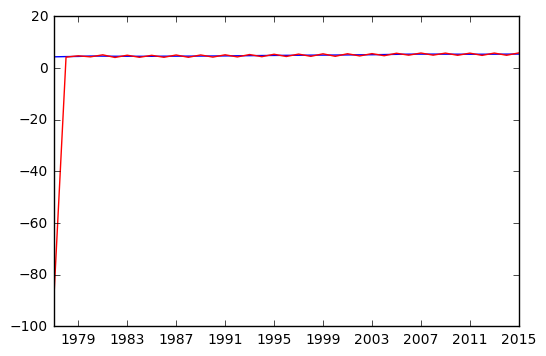

In [80]:
model_Combined = Combined_Model(ts_log)

In [81]:
aic_metric

,AIC,Modelname
0,-135.951622,"ARIMA(ts, order=(2, 0, 0))"
0,-52.415691,"ARIMA(ts, order=(0, 0, 2))"
0,612.307811,"ARIMA(ts, order=(2, 0, 1))"


In [66]:

aic_dict

{'ARIMA(ts, order=(0, 1, 2))': -143.01395110852928,
 'ARIMA(ts, order=(2, 0, 0))': -135.95162222231727,
 'ARIMA(ts, order=(2, 0, 1))': 612.307811361123,
 'ARIMA(ts, order=(2, 0, 2))': 612.307811361123,
 'ARIMA(ts, order=(2, 1, 0))': -143.4160291093125,
 'ARIMA(ts, order=(2, 1, 1))': -145.8358352844566,
 'ARIMA(ts, order=(2, 1, 2))': -139.7663131979936}

In [67]:
#### Calculate best model
best_model =  min(aic_dict.items(),key=operator.itemgetter(1))[0]
print('Best Model is ', best_model)

Best Model is  ARIMA(ts, order=(2, 1, 1))


In [42]:
#Forecast using Best Model
def forecast(model,numSteps):
    #model.forecast(steps=numSteps)
    output = model.forecast(steps=numSteps)[0]
    output.tolist()
    output = np.exp(output)
    print(output)
    return output    

In [69]:
output_forecast = forecast(model_AR,5)

[ 233.35209132  234.64047779  234.61121852  233.71270466  232.25404704]


In [44]:
#AR model
#model = ARIMA(ts_log, order=(1, 1, 0))
#results_AR = model.fit(disp=0)  
#print(results_AR.summary())
#print('Lag: %s' % results_AR.k_ar)
#print('Coefficients: %s' % results_AR.params)
#plt.plot(ts_log_diff)
#plt.plot(results_AR.fittedvalues, color='red')


#MA model
#model = ARIMA(ts_log, order=(0, 1, 1))  
#results_MA = model.fit(disp=-1)  
#print('Lag: %s' % results_MA.k_ar)
#print('Coefficients: %s' % results_MA.params)
#print(results_MA.summary())
#plt.plot(ts_log_diff)
#plt.plot(results_MA.fittedvalues, color='red')


#Combined model
#model = ARIMA(ts_log, order=(1, 1, 2))  
#results_ARIMA = model.fit(disp=-1) 
#print('Lag: %s' % results_ARIMA.k_ar)
#print('Coefficients: %s' % results_ARIMA.params)
#print(results_ARIMA.summary())
#plt.plot(ts_log_diff)
#plt.plot(results_ARIMA.fittedvalues, color='red')